In [1]:
import numpy as np
from scipy import integrate   
import sys
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import pickle
import pandas as pd
sns.set_style("darkgrid")
pd.set_option('display.precision',1)
pd.set_option('display.float_format', '{:.2g}'.format)
sys.path.append(".")

from rsindy.rsindy_bayes import *
from rsindy.utils import *
from pp_model import *
import pp_rsindy as pp

### Model
$$
\begin{align*}
    X &\overset{k_1}{\to} 2X \\
    X + Y &\overset{k_2}{\to} 2Y \\
    Y &\overset{k_3}{\to} \phi \\
\end{align*}
$$

which can be translated into

$$
\begin{align*}
    \frac{dX}{dt} = k_1 X - k_2 XY \\
    \frac{dY}{dt} = k_2 X Y - k_3 Y 
\end{align*}
$$

### Observations

In [2]:
t = np.arange(0, 15, 0.2)
Z_obs, Z_obs_noisy = simulate_data(theta, t)

In [3]:
t_1, Z_obs_noisy_1 = t[::5], Z_obs_noisy[::5]
t_2, Z_obs_noisy_2 = t[::10], Z_obs_noisy[::10]

## Latent-Variable with Horseshoe Prior

In [63]:
bs_horseshoe = RSINDyRegularizedHorseshoe(species_names, custom_reaction_basis)

In [64]:
Z_obs_additive = Z_obs.sum(axis = 1)
Z_obs_additive_noisy = np.exp(np.log(Z_obs_additive) + np.random.normal(0, 0.2, size = Z_obs_additive.shape))
Z_obs_additive_noisy_1 = Z_obs_additive_noisy[::5]
Z_obs_additive_noisy_1[0] = Z_obs_additive[0]

In [66]:
fit_additive, _, Sa, Ra, Da = bs_horseshoe.fit_non_dx(
    X0 = Z_obs[0,:],
    X_obs = Z_obs_additive_noisy[1:].reshape(-1,1),
    ts = t,
    known_S = None,
    known_R = None,
    known_rates = [],
    regularized = True,
    additive = True,
    N = 16,
    model_params = {
        'slab_scale' : 2,
        'slab_df' : 2,
        'tau0' : 1e-4,
        'noise_sigma' : 0.2,
    },
    fit_params = {
        'chains' : 1,
        'iter_warmup' : 2000,
        'iter_sampling' : 1000,
        'show_progress' : 'notebook',
        'prior_predictive' : False
    },
shuffle = False)

INFO:cmdstanpy:compiling stan program, exe file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmpibqt0wji
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmpibqt0wji


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

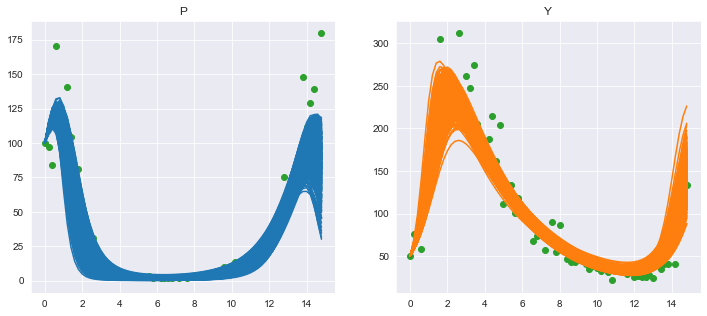

In [67]:
rates = fit_additive.stan_variables()['rates'][0:1000]
fig = bs_horseshoe.plot_simulated_trajectories(rates, Sa, Ra, [100, 50], t)
fig.set_size_inches(12, 5)
fig.axes[0].scatter(t, Z_obs_noisy[:,0], color = 'C2')
fig.axes[1].scatter(t, Z_obs_noisy[:,1], color = 'C2')

In [68]:
_, r = prune_reactions(fit_additive)

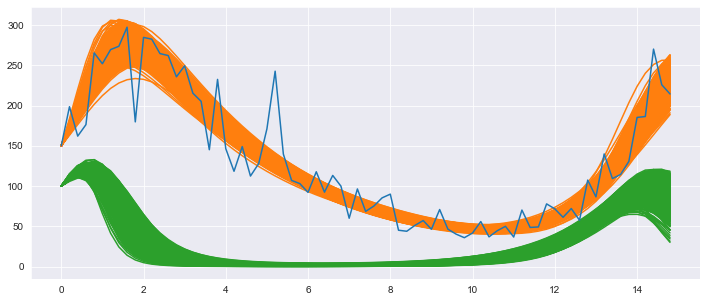

In [69]:
rates = fit_additive.stan_variables()['rates']
_, r = prune_reactions(fit_additive)
fig, ax = plt.subplots()
for i in range(rates.shape[0]):
    Z_est = solve_estimated_dynamics(rates[i,:], Sa, Ra, [100, 50], t)
    ax.plot(t, Z_est[:,0] + Z_est[:,1], color = 'C1')
    ax.plot(t, Z_est[:,0], color = 'C2')
ax.plot(t, Z_obs_additive_noisy)
fig.set_size_inches(12, 5)

In [70]:
prune_reactions(fit_additive)

(array([0.018, 0.009, 1.   , 1.   , 1.   , 0.031, 0.064, 0.01 , 0.057,
        0.027, 0.045, 0.047, 0.01 , 0.076, 0.038, 0.059]),
 array([2, 3, 4]))

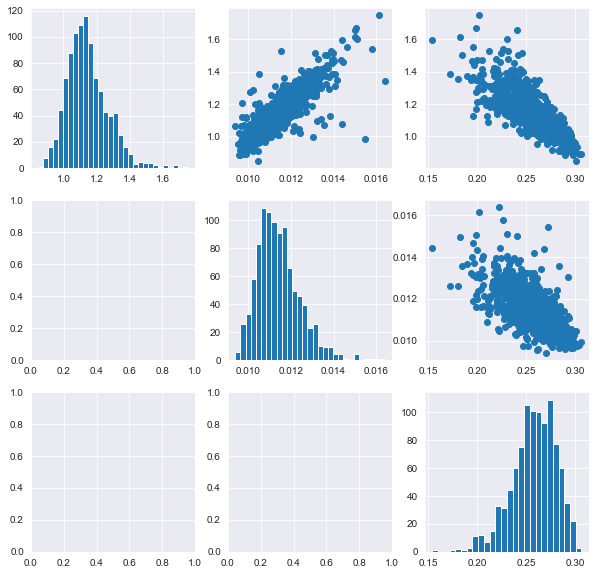

In [72]:
fig, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(i, 3):
        if i == j:
            ax[i,j].hist(rates[:,r[i]], bins = 'auto')
        else:
            ax[i,j].scatter(rates[:,r[j]], rates[:,r[i]])
fig.set_size_inches(10, 10)

(1000, 75)


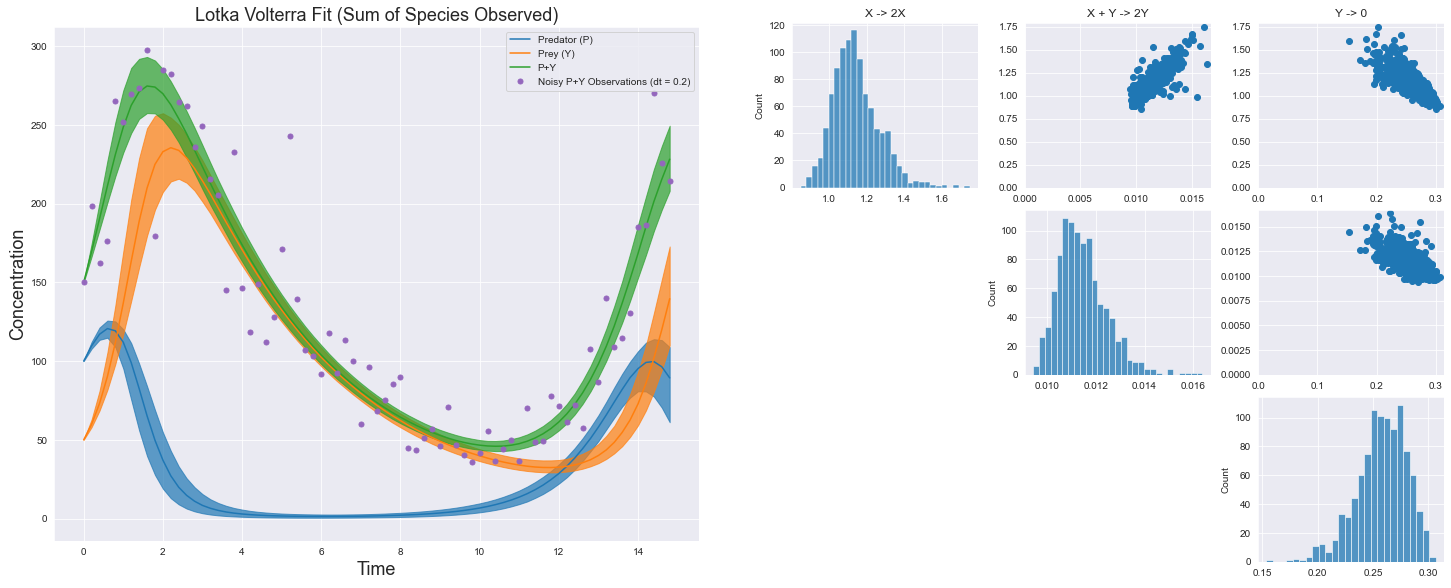

In [74]:
fig = plt.figure(constrained_layout=True, figsize=(20, 8))
subfigs = fig.subfigures(1, 2, wspace=0.07)
axl = subfigs[0].subplots()

species_names = ['P', 'Y']
fit = fit_additive
samples = fit_additive.stan_variables()['rates']
all_infs = []
sum_infs = []
for i in range(samples.shape[0]):
    Z_est = solve_estimated_dynamics(samples[i,:], Sa, Ra, [100, 50], t)
    all_infs.append(Z_est)
    sum_infs.append(Z_est.sum(axis = 1))

all_infs = np.stack(all_infs)
pct_20 = np.percentile(all_infs, 5, axis = 0)
pct_50 = np.percentile(all_infs, 50, axis = 0)
pct_80 = np.percentile(all_infs, 95, axis = 0)
for k in range(2):
    if k == 0:
        axl.plot(t, pct_50[:,k], color = 'C0', label = "Predator (P)", alpha = 1)
        axl.fill_between(t, pct_20[:,k], pct_80[:,k], color = 'C0', alpha = 0.7)
    else:
        axl.plot(t, pct_50[:,k], color = 'C1', label = "Prey (Y)", alpha = 1)
        axl.fill_between(t, pct_20[:,k], pct_80[:,k], color = 'C1', alpha = 0.7)

sum_infs = np.stack(sum_infs)
print(sum_infs.shape)
pct_20 = np.percentile(sum_infs, 5, axis = 0)
pct_50 = np.percentile(sum_infs, 50, axis = 0)
pct_80 = np.percentile(sum_infs, 95, axis = 0)
axl.plot(t, pct_50, color = 'C2', label = "P+Y", alpha = 1)
axl.fill_between(t, pct_20, pct_80, color = 'C2', alpha = 0.7)
        
axl.legend()     
axl.set_title("Lotka Volterra Fit (Sum of Species Observed)", fontsize = 18)
axl.set_xlabel("Time", fontsize = 18)
axl.set_ylabel("Concentration", fontsize = 18)
axl.plot(t, Z_obs_additive_noisy, '.', color = 'C4', markersize = 10, label = 'Noisy P+Y Observations (dt = 0.2)', alpha = 1)
axl.legend()

axr = subfigs[1].subplots(3,3)
for i in range(3):   
    axr[0,i].set_title(Da[r[i]])
    for j in range(i, 3):
        if i == j:
            sns.histplot(samples[:,r[i]], bins = 'auto', color = 'C0', ax = axr[i][j]);
        else:
            axr[i][j].scatter(samples[:,r[j]], samples[:,r[i]], color = 'C0')
            axr[i][j].set_xlim([0, None])
            axr[i][j].set_ylim([0, None])

            axr[j][i].axis('off')
plt.savefig("results/figs/additive_observations.png", dpi = 400)